1. Installing and Importing Python Libraries and Dependencies

In [1]:
!pip install geocoder
!pip install folium

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


2. Data Extraction and Cleaning

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [4]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [5]:
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [6]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [7]:
df.describe()

,Postalcode,Borough,Neighborhood
count,20,20,20
unique,20,20,20
top,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
freq,1,1,1


In [8]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [9]:
df.head()

,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [10]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [11]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,20,20,20
unique,20,20,20
top,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
freq,1,1,1


In [12]:
print(df_2.shape)
df_2.head()

(20, 3)


,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [13]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.708829585000046, -79.36612800699999]

In [14]:
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [15]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [16]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [17]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue),43.653524,-79.383907
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...,43.809160,-79.221690
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,43.786580,-79.188292
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned,43.769163,-79.182803
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned,43.767528,-79.217721
5,\nM1HScarborough(Cedarbrae)\n\n,\nM2HNorth York(Hillcrest Village)\n\n,M9HNot assigned,44.244715,-79.293276
6,\nM1JScarborough(Scarborough Village)\n\n,\nM2JNorth York(Fairview / Henry Farm / Oriole...,M9JNot assigned,43.740615,-79.208887
7,\nM1KScarborough(Kennedy Park / Ionview / East...,\nM2KNorth York(Bayview Village)\n\n,M9KNot assigned,43.711087,-79.269800
8,\nM1LScarborough(Golden Mile / Clairlea / Oakr...,\nM2LNorth York(York Mills / Silver Hills)\n\n,M9LNorth York(Humber Summit),43.696632,-79.282859
9,\nM1MScarborough(Cliffside / Cliffcrest / Scar...,\nM2MNorth York(Willowdale / Newtonbrook)\n\n,M9MNorth York(Humberlea / Emery),43.653524,-79.383907


In [18]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent='your unique UA')
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.7729744, -79.2576479.


3. Map of Scarborough

In [19]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [20]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent='your unique UA')
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7729744, -79.2576479.


In [21]:
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [22]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [23]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups', 'venue.events.count',
       'venue.events.summary', 'venue.location.neighborhood',
       'venue.venuePage.id'],
      dtype='object')

In [24]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

4. Nearby Venues/Locations

In [25]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775512,-79.258288
3,Coliseum Scarborough Cinemas,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",43.775995,-79.255649
4,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662


5. Categories of Nearby Venues/Locations

In [26]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,American Eagle Store,Clothing Store,43.776012,-79.258334
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,SEPHORA,Cosmetics Shop,43.775512,-79.258288
3,Coliseum Scarborough Cinemas,Movie Theater,43.775995,-79.255649
4,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662


In [27]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store         8
Restaurant             4
Coffee Shop            3
Gas Station            2
Sporting Goods Shop    2
Department Store       2
Sandwich Place         2
Pharmacy               2
Fish & Chips Shop      1
Cosmetics Shop         1
Name: categories, dtype: int64

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

M9AEtobicoke(Islington Avenue)
M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)
M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood)
M9ENot assigned
M9GNot assigned
M9HNot assigned
M9JNot assigned
M9KNot assigned
M9LNorth York(Humber Summit)
M9MNorth York(Humberlea / Emery)
M9NYork(Weston)
M9PEtobicoke(Westmount)
M9REtobicoke(Kingsview Village / St. Phillips / Martin Grove Gardens / Richview Gardens)
M9SNot assigned
M9TNot assigned
M9VEtobicoke(South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thistletown / Albion Gardens)
M9WEtobicokeNorthwest(Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)
M9XNot assigned
M9YNot assigned
M9ZNot assigned


In [30]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 106 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
M9AEtobicoke(Islington Avenue),100,100,100,100,100,100
M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale),17,17,17,17,17,17
M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood),10,10,10,10,10,10
M9ENot assigned,34,34,34,34,34,34
M9GNot assigned,6,6,6,6,6,6


In [31]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Vietnamese Restaurant,American Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Garage,Automotive Shop,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Butcher,Café,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Fast Food Restaurant,Fish Market,Food & Drink Shop,Food Court,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Laundromat,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Noodle House,Office,Park,Peking Duck Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Poke Place,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Speakeasy,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tanning Salon,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,University,Vegetarian / Vegan Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Most Common venues near neighborhood

In [34]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M9AEtobicoke(Islington Avenue),Coffee Shop,Hotel,Café,Clothing Store,Furniture / Home Store,New American Restaurant,Middle Eastern Restaurant,Concert Hall,Plaza,Gym
1,M9BEtobicoke(West Deane Park / Princess Garden...,Fast Food Restaurant,Pizza Place,Park,Gym / Fitness Center,Pharmacy,Convenience Store,Skating Rink,Supermarket,Grocery Store,Sandwich Place
2,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,Coffee Shop,Gym,Burger Joint,Pub,Fried Chicken Joint,Café,Recreation Center,Mediterranean Restaurant,Gas Station,Peking Duck Restaurant
3,M9ENot assigned,Pizza Place,Pharmacy,Coffee Shop,Breakfast Spot,Fast Food Restaurant,Automotive Shop,Thrift / Vintage Store,Sandwich Place,Convenience Store,Grocery Store
4,M9GNot assigned,Department Store,Fast Food Restaurant,Coffee Shop,Sandwich Place,Chinese Restaurant,Park,Noodle House,Poke Place,Plaza,Pizza Place


K-Means Clustering Approach

In [35]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2])

In [36]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue),43.653524,-79.383907,2.0,Coffee Shop,Hotel,Café,Clothing Store,Furniture / Home Store,New American Restaurant,Middle Eastern Restaurant,Concert Hall,Plaza,Gym
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...,43.809160,-79.221690,0.0,Fast Food Restaurant,Pizza Place,Park,Gym / Fitness Center,Pharmacy,Convenience Store,Skating Rink,Supermarket,Grocery Store,Sandwich Place
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,43.786580,-79.188292,2.0,Coffee Shop,Gym,Burger Joint,Pub,Fried Chicken Joint,Café,Recreation Center,Mediterranean Restaurant,Gas Station,Peking Duck Restaurant
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned,43.769163,-79.182803,0.0,Pizza Place,Pharmacy,Coffee Shop,Breakfast Spot,Fast Food Restaurant,Automotive Shop,Thrift / Vintage Store,Sandwich Place,Convenience Store,Grocery Store
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned,43.767528,-79.217721,0.0,Department Store,Fast Food Restaurant,Coffee Shop,Sandwich Place,Chinese Restaurant,Park,Noodle House,Poke Place,Plaza,Pizza Place


Map of Clusters

In [37]:
kclusters = 10

In [38]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow,
        fill=True,
        fill_color=rainbow,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [39]:

df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [40]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               335000.0,286600.0,175000.0
                                                                        ]})
                                                              
                                                              
                                                    

In [41]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot: xlabel='Neighborhood'>

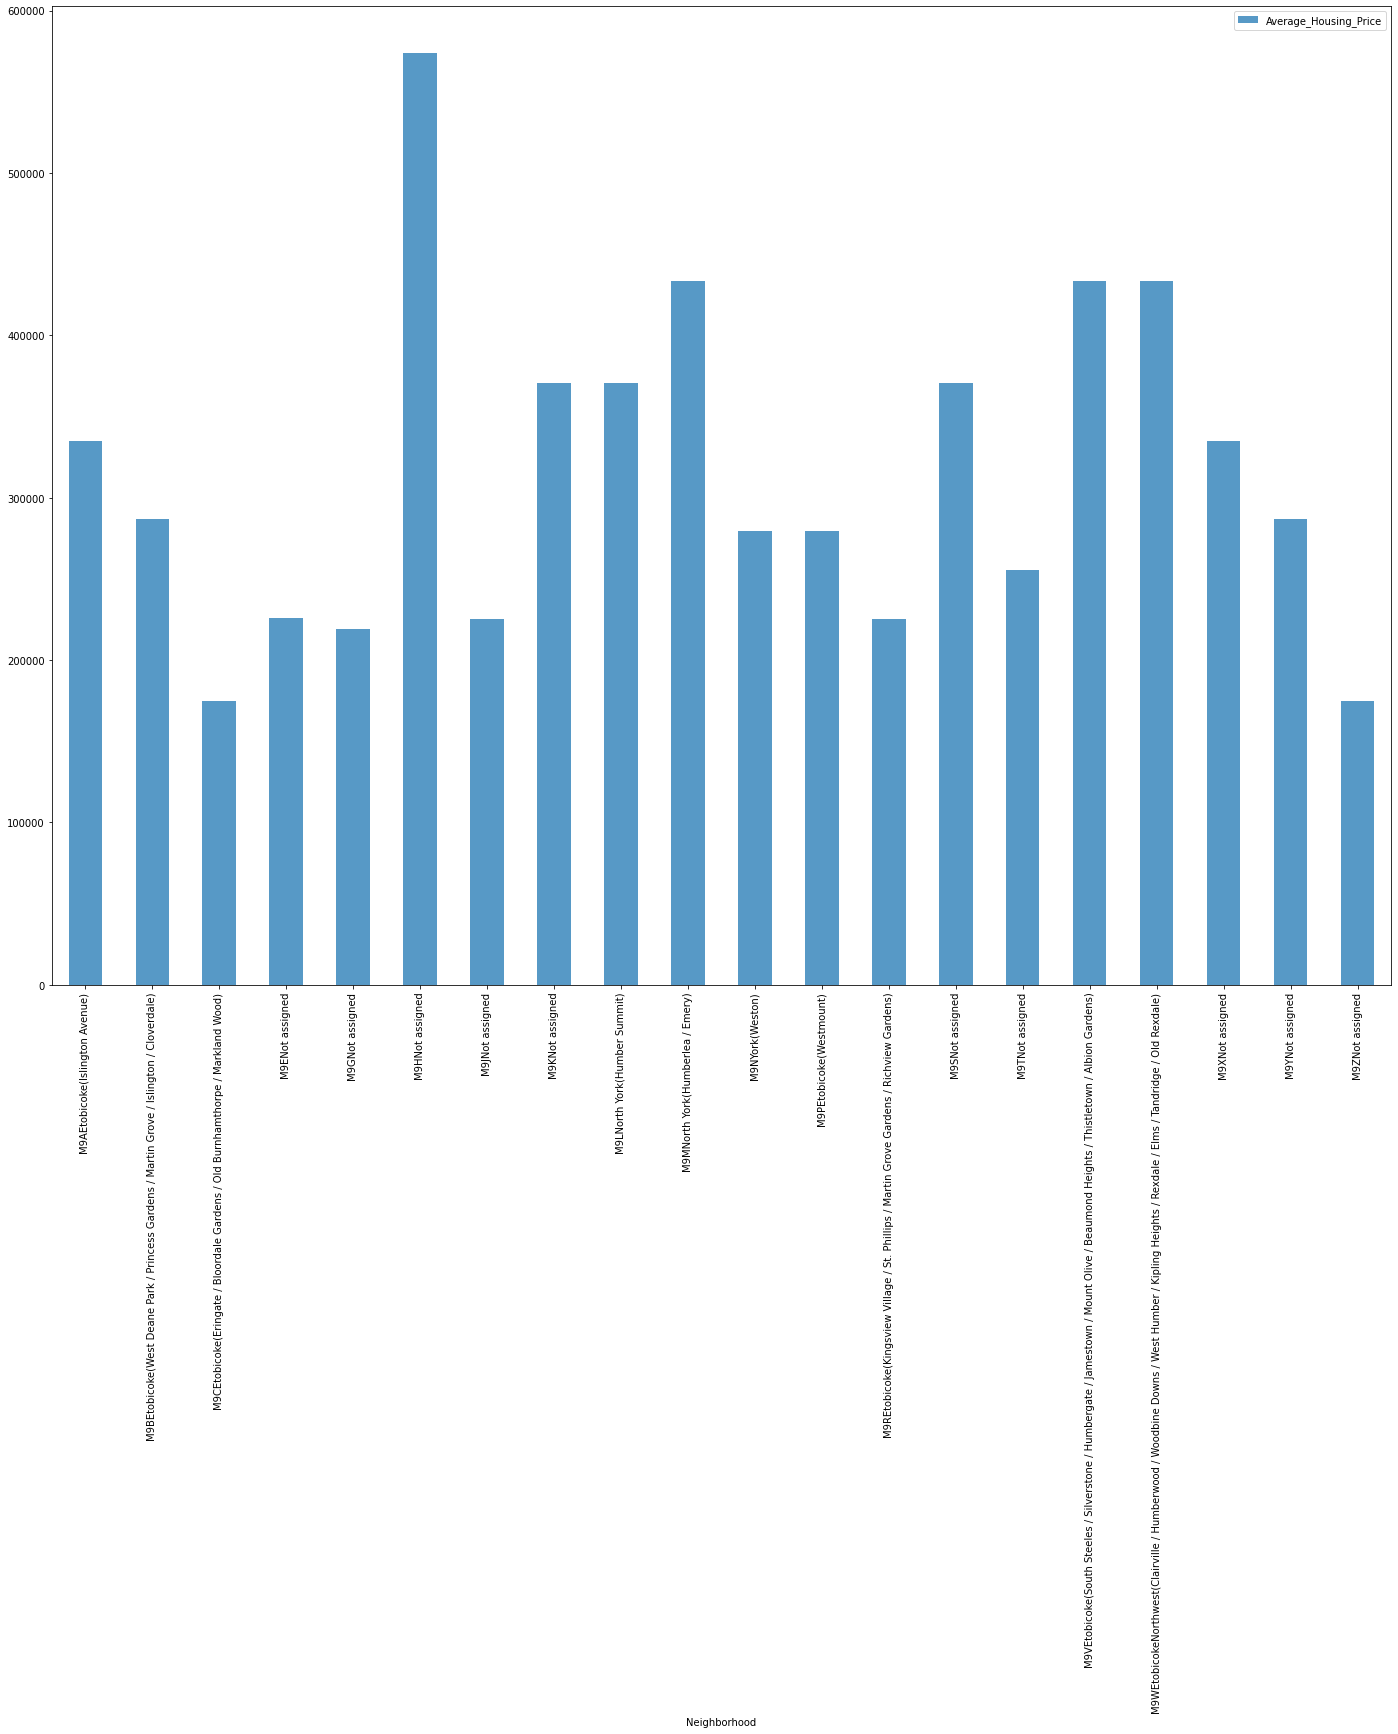

In [42]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

School Rating by Clusters

In [43]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [44]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,5,10,1,2,7,2,3,2,6,
                                                           5,4,8,5,4,6,8,9,6,2
                                                         
                                                           ]})

In [45]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

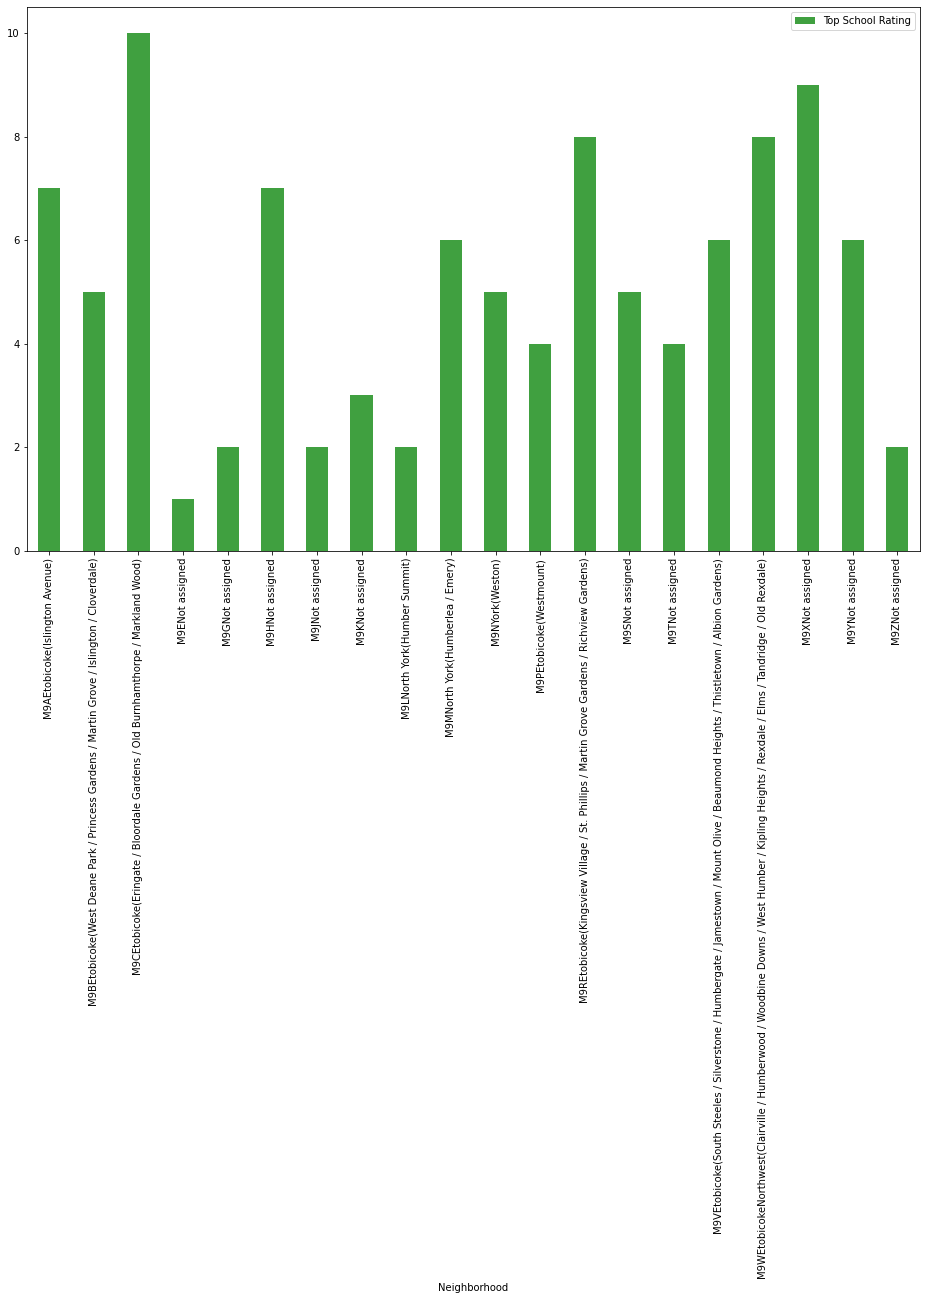

In [46]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);